# Step 1: Data Preparation

Here, we explain how to use our code to extract the sub-tomogram pairs $\big\{({\color{red}\mathbf{v}^0_{\color{white}i}}, {\color{blue}\mathbf{v}^1_{\color{white}i}})\big\}_{i=1}^N$ which we use to construct the model inputs and targets for model fitting in Step 2.

In [1]:
import os
import shutil
import torch
from typer_config.loaders import yaml_loader

from ddw import prepare_data
from ddw.utils.subtomo_dataset import SubtomoDataset
from ddw.utils.visualization import plot_tomo_slices
from ddw.utils.print import pprint_dict, print_help_for_function_arguments

## Running Data Preparation for the Tutorial Data

There are two ways to run the data preparation step: either by running the `prepare_data` function directly in python, or by running the `ddw prepare-data` command-line command. The recommended way is to use the command-line command together with a `yaml` config file, which we demonstrate here.

In [2]:
config = yaml_loader("./config.yaml")
project_dir = config["shared"]["project_dir"]
if os.path.exists(project_dir):
    shutil.rmtree(project_dir)

In [3]:
!conda run --no-capture-output -n ddw_env ddw prepare-data --config ./config.yaml

Saving all subtomograms to 'tutorial_project/subtomos'.
Starting subtomogram extraction from 1 tomogram(s).
Masking selected 314/336 subtomos extracted from tomogram 0
Done with sub-tomogram extraction.
Saved a total of 251 sub-tomograms for model fitting to 'tutorial_project/subtomos/fitting_subtomos'.
Saved a total of 63 sub-tomograms for validation to 'tutorial_project/subtomos/val_subtomos'.


Above, the `conda run -n ddw_env` part of the command is necessary to ensure that the correct python environment is used. If you are not using conda, or if you are on the commandline and `ddw_env` is active, you can remove this part of the command.

Let's now inspect the sub-tomogram pair $({\color{red}\mathbf{v}^0_{\color{white}0}}, {\color{blue}\mathbf{v}^1_{\color{white}0}})$:

/tmp/ipykernel_2292788/2529064065.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fitting_subtomo0 = torch.load("./tutorial_project/subtomos/fitting_subtomos/subtomo0/0.

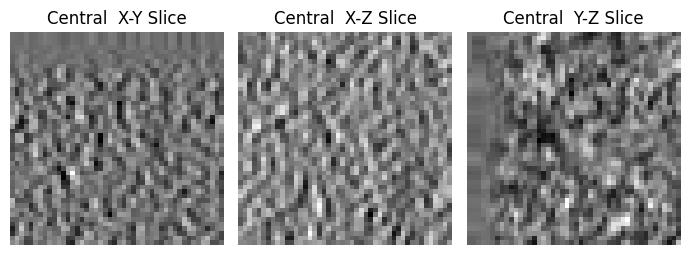

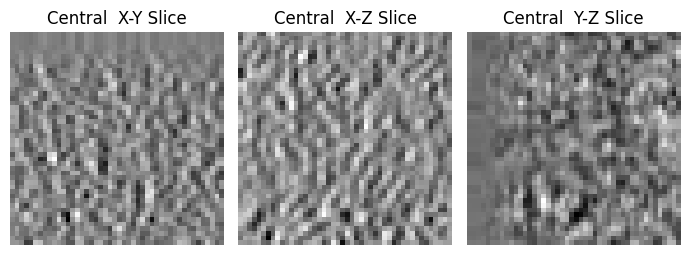

In [4]:
fitting_subtomo0 = torch.load("./tutorial_project/subtomos/fitting_subtomos/subtomo0/0.pt")
fitting_subtomo1 = torch.load("./tutorial_project/subtomos/fitting_subtomos/subtomo1/0.pt")

plot_tomo_slices(fitting_subtomo0).show()
plot_tomo_slices(fitting_subtomo1).show()

**Note:** Although the subtomogram size in `./config.yaml` is set to $96$, the sub-tomograms ${\color{red}\mathbf{v}^0_{\color{white}0}}$, and ${\color{blue}\mathbf{v}^1_{\color{white}0}}$ are actually of size $136 \approx \sqrt{2} * 96$. This is because for model fitting, we randomly rotate the sub-tomograms. If we extract sub-tomograms of size $96$, the rotated sub-tomograms will have black borders for some rotations. To avoid this, sub-tomograms are automatically extracted with this larger shape, and then cropped to shape $96$ after rotation during the generation of the model inputs and targets (see next notebook).

In [5]:
print(fitting_subtomo0.shape)
print(fitting_subtomo1.shape)

torch.Size([46, 46, 46])
torch.Size([46, 46, 46])


Internally, the command 
```
ddw prepare-data --config ./config.yaml
```
calls the function `ddw.prepare_data.prepare_data` with the parameters specified in the `config.yaml` file. We first discuss the most important parameters of the `prepare_data` function, and then show how to specify them in the `config.yaml` file.

## Most Important Parameters of `prepare_data` 

You can find a full list of parameters for `ddw prepare-data` by executing
```
ddw prepare-data --help
```
in the commandline. Here, we only discuss the most important parameters.


The most important parameters are the tomogram pairs (e.g. FBP reconstructions of tilt series based on disjoint two halves of the movie frames) from which the sub-tomogram pairs are extracted, abd the size of the sub-tomograms:

In [ ]:
print_help_for_function_arguments(prepare_data, print_only_required=True)


Another important (but not required) parameter are 3 stride values for the 3D sliding window procedure used to extract the sub-tomograms. Using smaller strides will result in more sub-tomograms, but also in more overlap between them.

In [ ]:
print_help_for_function_arguments(prepare_data, arg_names=["subtomo_extraction_strides"])

Another way to influence sub-tomogram extraction is by using binary masks that outline the region of interest (ROI) in the tomograms. This can be useful if the ROI is known to be smaller than the full tomogram size, or if the ROI is not centered in the tomogram. The masks should be binary 3D arrays saved as `.mrc` files of the same size as the tomograms, with 1s indicating the ROI and 0s indicating the background. In this tutorial, we use a mask generated with IsoNet's `make_mask` command using the default parameters.

In [ ]:
print_help_for_function_arguments(prepare_data, arg_names=["mask_files", "min_nonzero_mask_fraction_in_subtomo"])

## The `config.yaml` File

While all parameters of the `prepare_data` function can be specified directly in python or in the commandline, we recommend using a `yaml` config file for better readability and reproducibility. Using our tutorial config `./config.yaml`, we now explain how to specify parameters for `prepare_data`.

In [ ]:
config = yaml_loader("./config.yaml")
print(config.keys())

The important config entries for data preparation are:
- `prepare_data`: Parameters that are specific to the data preparation step.
- `shared`: Parameters that are shared between all steps of the pipeline. Note that some of these parameters are not used in `pepare_data` but for other steps. All parameters specified in `shared` can be overwritten by the specific step parameters.

In [ ]:
pprint_dict(config["prepare_data"])

In [ ]:
pprint_dict(config["shared"])